## **RAG based QnA**

In [1]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_huggingface import HuggingFaceEmbeddings

## **Load the LLM and Embedding Model**

In [2]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Load the PineCone Cloud Vector DB**

In [3]:
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore

os.environ["PINECONE_API_KEY"] = os.getenv("PINECONE_API_KEY")

pinecone_api_key = os.getenv("PINECONE_API_KEY")
pc = Pinecone(api_key=pinecone_api_key)

index_name = "samsung-db"
index = pc.Index(index_name)

vector_store = PineconeVectorStore(index=index, embedding=embeddings)
vector_store

## **Vector store as Retriever**

In [4]:
retriever = vector_store.as_retriever(
    search_type = "similarity",
    search_kwargs={
        "k": 3
    }
)

## **RAG Prompt**

In [5]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    template="""
You are a helpful AI assistant and an expert at answering Samsung phone-related questions.
Your job is to provide **clear and direct answers** using the correct document.

do not mention this type of response:

example:

    The user is asking about the camera specs of the Samsung Galaxy S23 Ultra.

    After checking the metadata of the retrieved documents, I found an exact match: `samsung_galaxy_s23_ultra`.
Answer clear and direct way like normally answer the user question according the context.

- You will receive two documents as context.
- Only use the document where the metadata `phone_name` exactly matches the phone model in the user's question.
- If no document matches, say: "Sorry, I do not know the answer because the correct phone model was not found in the retrieved context."
- Do not explain how you found the information. Just provide the final answer clearly and concisely.

⚠ Example of phone name matching:  
If the user question mentions **"Samsung Galaxy S23 Ultra"**  
and a document metadata has **phone_name: samsung_galaxy_s23_ultra**  
→ this is an exact match.

---

User question:  
{question}

---

Retrieved documents:  
{context}
""",
    input_variables=["question", "context"]
)

In [6]:
from langchain_core.runnables import RunnablePassthrough

def format_docs(retriever_docs):
    context_text = ""
    for doc in retriever_docs:
        phone_name = doc.metadata.get("phone_name", "unknown")
        context_text += f"Phone name (metadata): {phone_name}\n"
        context_text += f"{doc.page_content}\n\n"
    # print(context_text)
    return context_text.strip()

## **Chain Building**

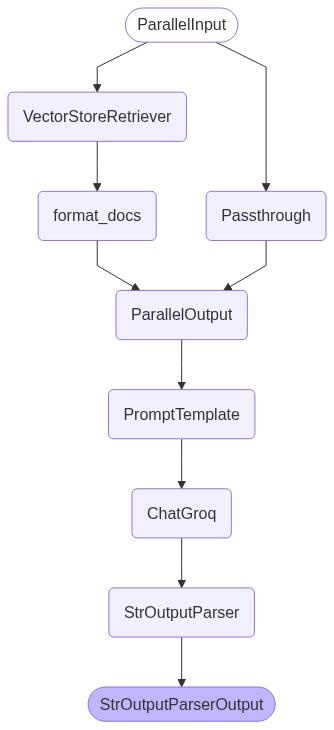

In [12]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

from IPython.display import display, Image, Markdown
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    }
    | prompt
    | llm
    | StrOutputParser()
)


display(Image(rag_chain.get_graph().draw_mermaid_png()))

## QnA Testing

In [9]:
question = "What is the screen size of the Galaxy S23?"
response = rag_chain.invoke(question)
print(response)

The screen size of the Galaxy S23 is 6.1 inches.


In [13]:
question = "What are the camera specs of the Samsung Galaxy S23 Ultra?"
response = rag_chain.invoke(question)
Markdown(response)

The camera specs of the Samsung Galaxy S23 Ultra are:

* Main Camera: Quad camera with:
	+ 200 MP, f/1.7, 24mm (wide), 1/1.3", 0.6µm, multi-directional PDAF, OIS
	+ 10 MP, f/2.4, 70mm (telephoto), 1/3.52", 1.12µm, PDAF, OIS, 3x optical zoom
	+ 10 MP, f/4.9, 230mm (periscope telephoto), 1/3.52", 1.12µm, PDAF, OIS, 10x optical zoom
	+ 12 MP, f/2.2, 13mm, 120˚ (ultrawide), 1/2.55", 1.4µm, dual pixel PDAF, Super Steady video
* Features: Laser AF, LED flash, auto-HDR, panorama
* Video: 8K@24/30fps, 4K@30/60fps, 1080p@30/60/120/240fps, HDR10+, stereo sound rec., gyro-EIS

* Selfie camera: 
	+ 12 MP, f/2.2, 26mm (wide), 1/3.2", 1.12µm, dual pixel PDAF
	+ Features: HDR, HDR10+
	+ Video: 4K@30/60fps, 1080p@30fps

# **Multi Agent Review Systems**

### ***Connect With `MySQL` DB***

In [14]:
import mysql.connector
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='',
    database='device_specs_db'
)

In [15]:
from sqlalchemy import create_engine

engine = create_engine('mysql+pymysql://root:@localhost/device_specs_db')

In [17]:
from sqlalchemy import text
import pandas as pd

phone_name = "Samsung Galaxy A06 5G"
query = text("SELECT * FROM samsung_phone WHERE phone_name = :phone_name")
df = pd.read_sql(query, con=engine, params={"phone_name": phone_name})

context_str = df.iloc[0].to_string()
context_str

'phone_name                                          Samsung Galaxy A06 5G\nnetwork_technology                                  GSM / HSPA / LTE / 5G\nnetwork_2g_bands                              GSM 850 / 900 / 1800 / 1900\nnetwork_3g_bands                HSDPA 850 / 900 / 1700(AWS) / 1900 / 2100\nnetwork_4g_bands        1, 2, 3, 4, 5, 7, 8, 12, 17, 20, 26, 28, 38, 4...\nnetwork_5g_bands        1, 3, 5, 7, 8, 26, 28, 40, 41, 66, 77, 78 SA/N...\nnetwork_speed                                               HSPA, LTE, 5G\nlaunch_announced                                        2025, February 19\nlaunch_status                       Available. Released 2025, February 19\nbody_dimensions               167.3 x 77.3 x 8 mm (6.59 x 3.04 x 0.31 in)\nbody_weight                                               191 g (6.74 oz)\nbody_build                       Glass front, plastic back, plastic frame\nbody_sim                                              Nano-SIM + Nano-SIM\ndisplay_type            

## **Phone Name extraction From User Query**

In [18]:
from pydantic import BaseModel, Field
from typing import Annotated

class PhoneName(BaseModel):
    """This class is responsible for extract the phone name form the user query."""
    
    phone_name: Annotated[str, Field(description="Extract the phone name only form the user query and follow this rule: each word starts with a capital letter, numbers and suffixes are as in model name")]

In [19]:
from langchain_core.output_parsers import PydanticOutputParser
phone_name_parser = PydanticOutputParser(pydantic_object=PhoneName)

## **Phone Name extraction Prompt**

In [20]:
from langchain_core.prompts import PromptTemplate


phone_name_prompt = PromptTemplate(
    template="""
You are an AI assistant responsible for extracting phone names from user queries about Samsung phones.

Your task:
- Extract the exact phone name mentioned in the user's query.
- The phone name must follow this style: each word starts with a capital letter, numbers and suffixes are as in the model name.
- Return only the phone name in the structured format expected by the system (do not include any extra text or explanation).

Examples:

User query: "Tell me about the samsung galaxy s23 ultra"
Extracted phone_name: "Samsung Galaxy S23 Ultra"

User query: "What is the battery life of the galaxy a06 5g?"
Extracted phone_name: "Samsung Galaxy A06 5G"

User query: "Give specs for samsung galaxy m15"
Extracted phone_name: "Samsung Galaxy M15"

---

Now extract the phone name from this user query:

User query: {question}

Return the result as a this output format instruction: {format_instruction}
""",
    input_variables=["question"],
    partial_variables={
            "format_instruction": phone_name_parser.get_format_instructions()
        }
)

In [24]:
ph_name_extract_chain = phone_name_prompt | llm | phone_name_parser

## Test query
response = ph_name_extract_chain.invoke("Tell me about the samsung galaxy s23 ultra")
response.phone_name

'Samsung Galaxy S23 Ultra'

## Build the Agent State

In [30]:
from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage
from pydantic import Field
import operator

class State(TypedDict):
    """This is is my graph state where store all conversations."""
    messages: Annotated[Sequence[BaseMessage], operator.add]
    ph_raw_data: Annotated[str, Field(description="This raw data extract form MySQL DB")]

## **Data extraction Node**

In [31]:
def data_extraction(state: State):
    print("--Data extraction--")
    question = state["messages"][-1]
    
    ## query into the db
    response = ph_name_extract_chain.invoke(question)

    phone_name = response.phone_name
    
    query = text("SELECT * FROM samsung_phone WHERE phone_name = :phone_name")
    df = pd.read_sql(query, con=engine, params={"phone_name": phone_name})
    context_str = df.iloc[0].to_string()
    print("---Data extraction done---")
    
    # print(context_str)
    return {
        "ph_raw_data": context_str
    }

## **Review Generate Prompt**

In [37]:

from langchain_core.prompts import PromptTemplate

review_prompt = PromptTemplate(
    template="""
You are the world's best phone reviewer, known for writing engaging, insightful, and professional reviews that captivate readers.

Your task:
- Use the provided phone context to generate a detailed, interesting, and natural-sounding review as a professional reviewer would write.
- The review should directly address the user's question when possible.
- Highlight key specs, features, and notable aspects that would matter to buyers (e.g., network, display, battery, camera, design).
- Make the review flow smoothly — not as a list of specs but as a narrative that excites readers.
- If the context is empty or missing important information, simply say:  
**"This phone is not available in our store."**  
Do not attempt to guess or generate fake details. and make sure write into the Markdown structured format.

---

📌 **User Question:**  
{question}

📌 **Phone Context (use this for your review):**  
{context}
""",
    input_variables=["question", "context"]
)

## **Review Generate Node**

In [38]:
from langchain_core.output_parsers import StrOutputParser

def review_generate(state: State):
    print("--Review generate--")
    question = state['messages'][-1]
    phone_context = state["ph_raw_data"]
    print(question)
    # print(phone_context)
    
    review_chain = review_prompt | llm | StrOutputParser()
    # response = llm.invoke(question)
    
    response = review_chain.invoke(
        {
            "question": question,
            "context": phone_context
        }
    )
    
    return {
        "messages": [response]
    }

## **Multi Agent Graph Workflow**

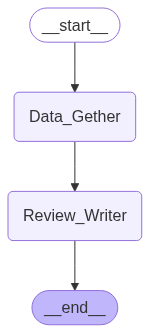

In [39]:
from langgraph.graph import START, END, StateGraph
from IPython.display import display, Image, Markdown

builder = StateGraph(State)

## define node
builder.add_node("Data_Gether", data_extraction)
builder.add_node("Review_Writer", review_generate)

## Define edges
builder.add_edge(START, "Data_Gether")
builder.add_edge("Data_Gether", "Review_Writer")
builder.add_edge("Review_Writer", END)

app = builder.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [40]:
output = app.invoke(
    {
        "messages": ["Please write review to samsung galaxy s25 ultra phone"]
    }
)

--Data extraction--
---Data extraction done---
--Review generate--
Please write review to samsung galaxy s25 ultra phone


In [41]:
Markdown(output["messages"][-1])

# Samsung Galaxy S25 Ultra Review: A Powerhouse of Innovation
The Samsung Galaxy S25 Ultra is the latest flagship device from the tech giant, and it's packed with an array of impressive features that are sure to leave even the most discerning users in awe. With its powerful Qualcomm Snapdragon 8 Elite chipset, stunning Dynamic LTPO AMOLED 2X display, and a camera system that's capable of capturing 8K video, this phone is a powerhouse of innovation.

## Design and Display
The Galaxy S25 Ultra boasts a sleek and durable design, with a glass front protected by Corning's Gorilla Armor 2 and a titanium frame that gives it a premium feel. The phone's dimensions are 162.8 x 77.6 x 8.2 mm, making it comfortable to hold and use, and it weighs in at 218g. The device features a 6.9-inch Dynamic LTPO AMOLED 2X display with a 120Hz refresh rate, 480Hz PWM, and HDR10+ support. With a resolution of 1440 x 3120 pixels and a 19.5:9 aspect ratio, the screen is incredibly vibrant and detailed, making it perfect for watching videos, browsing the web, or gaming.

## Performance
Under the hood, the Galaxy S25 Ultra is powered by the Qualcomm SM8750-AB Snapdragon 8 Elite chipset, built on a 3nm process. This powerful processor is paired with an octa-core CPU, featuring two 4.47 GHz Oryon V2 Phoenix L cores and six 3.2 GHz cores, along with the Adreno 830 GPU. This configuration ensures that the phone delivers lightning-fast performance, seamless multitasking, and effortless handling of demanding tasks. The phone comes with a range of storage options, including 256GB, 512GB, and 1TB, all paired with 12GB of RAM.

## Camera Capabilities
The camera system on the Galaxy S25 Ultra is one of its standout features. The phone boasts a quad-camera setup with a 200MP primary sensor, along with a 12MP front-facing camera. The main camera can capture stunning 8K video at 24/30fps, as well as 4K video at 30/60/120fps. Other camera features include laser autofocus, Best Face, LED flash, auto-HDR, and panorama mode. The selfie camera can record 4K video at 30/60fps and 1080p at 30fps.

## Battery Life and Charging
The Galaxy S25 Ultra is equipped with a 5000mAh Li-Ion battery, which provides all-day battery life. The phone supports 45W wired charging, which can charge the battery to 65% in just 30 minutes, as well as 15W wireless charging and reverse wireless charging.

## Additional Features
The phone also comes with a range of other impressive features, including stereo speakers, an under-display ultrasonic fingerprint sensor, and support for Wi-Fi 7, Bluetooth 5.4, and NFC. The device runs on Android 15 and is eligible for up to 7 major Android upgrades.

## Verdict
The Samsung Galaxy S25 Ultra is a powerhouse of a device that checks all the right boxes. With its stunning display, powerful performance, advanced camera capabilities, and long-lasting battery life, it's a top contender for anyone in the market for a new flagship smartphone. While it may not have a headphone jack or a microSD card slot, the phone's many features and capabilities make up for these omissions. Overall, the Galaxy S25 Ultra is an excellent choice for anyone looking for a premium Android device.

### Key Specifications:

* **Network:** GSM / CDMA / HSPA / EVDO / LTE / 5G
* **Display:** 6.9-inch Dynamic LTPO AMOLED 2X, 120Hz, 480Hz PWM, HDR10+
* **Processor:** Qualcomm SM8750-AB Snapdragon 8 Elite (3 nm)
* **Memory:** 256GB, 512GB, 1TB (all with 12GB RAM)
* **Camera:** Quad-camera setup with 200MP primary sensor, 12MP front-facing camera
* **Battery:** 5000mAh Li-Ion, 45W wired charging, 15W wireless charging
* **Operating System:** Android 15, up to 7 major Android upgrades

## Rating: 5/5

The Samsung Galaxy S25 Ultra is a top-of-the-line device that offers an unparalleled smartphone experience. Its impressive features, powerful performance, and stunning display make it a must-have for anyone looking for a premium Android device.

# ***Combine Two System Together***